In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

The algorithm used to carry out this processing is known as the Range-Doppler Algorithm (RDA). This algorithm implements a series of steps on the acquired data, both in the range domain and in the azimuth domain, as illustrated in the block diagram of Figure:

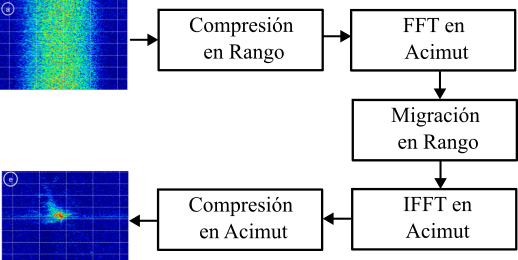

In this work, the Range Doppler Algorithm (RDA) is initially implemented using simulated Synthetic Aperture Radar (SAR) data focused on a point target. Subsequently, after completing the processing on the point target, the application of the algorithm is extended to real data sets acquired from an aircraft.

In [25]:
# Load a Matlab file
# mat = scipy.io.loadmat('raw_puntal_sim.mat')    # point target data
mat = scipy.io.loadmat('raw_aeropuerto.mat')

# Extract parameters
raw = mat.get('raw')
Tp = mat.get('Tp')[0,0]           # Pulse duration
te = mat.get('te')[0,0]           # Time delay between the end of the pulse and the start of the reception window [s]
BW = mat.get('chirp_BW')[0,0]     # Chirp bandwidth
fs = mat.get('fs')[0,0]           # Sampling frequency
PRF = mat.get('PRF')[0,0]         # Pulse repetition frequency
vr = mat.get('Vr')[0,0]           # Radial velocity
Fc = mat.get('Fc')[0,0]           # Carrier frequency
La = mat.get('La')[0,0]           # Antenna length


c = 3e8                           # ligth velocity
sz_col = len(raw[:,0])            # column size
sz_raw = len(raw[0,:])            # raw size


lamb = c/Fc                       # wavelength
r_min = (c*(te+Tp)/2)
r_max = (r_min + c*sz_raw/(2*fs))

# Range vector
rang = np.linspace(r_min, r_max, sz_raw)/1000
maximum_azimuth = sz_col*vr/(1000*PRF)

# Functions Initialization

In [26]:
# Rectangle function
def rect(x):
    if(x < 1/2 and x > -1/2):
        return 1
    else:
        return 0

# Chirp
def chirp(t, T, K):
    s = rect(t/T) * np.exp(1j * np.pi * K * t**2)
    return s

def compression2(y, H):
    Y = np.fft.fftshift(np.fft.fft(y))
    M = H * Y

    m = np.fft.ifftshift(np.fft.ifft(M))

    return m

# Compression
def compression(y, h):
    size_conv = np.size(y) + np.size(h) - 1
    size_fft = 2**(size_conv - 1).bit_length()

    Y = np.fft.fft(y, size_fft, norm="ortho")
    H = np.fft.fft(h, size_fft, norm="ortho")
    M = np.zeros(size_fft, dtype=complex)
    M = np.sqrt(size_fft) * H * Y
    m = np.fft.ifft(M, n=size_fft, norm="ortho")

    i1 = int(len(h) / 2)
    i2 = len(y) + int(len(h) / 2)

    if(i2 - i1 != len(y)):
        i2 += 1

    return m[i1:i2]



# **Colormap of Original Matrix Data**

<ipython-input-27-e4bbf6585fbf>:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(20 * np.log10(np.abs(raw)), cmap='viridis', aspect='auto', extent=(rang[0], rang[-1], maximum_azimuth, 0))


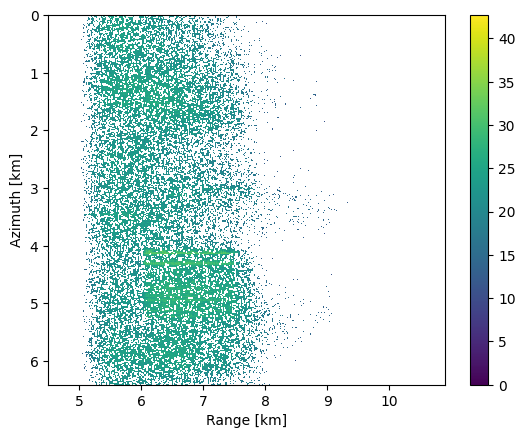

In [27]:
plt.imshow(20 * np.log10(np.abs(raw)), cmap='viridis', aspect='auto', extent=(rang[0], rang[-1], maximum_azimuth, 0))
plt.colorbar()  # Add color bar displaying the scale of values
plt.xlabel("Range [km]")
plt.ylabel("Azimuth [km]")

plt.show()


# **Range Compression**

To perform range compression, a filter adapted to each reception window was applied, with the form $h(t) = s*(-t)$, where $s(t)$ represents the transmitted signal. To improve the efficiency of the algorithm, the convolution theorem was implemented.

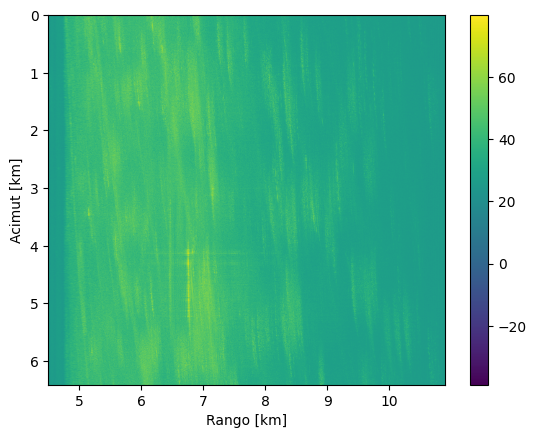

In [28]:
# Duration vector of my signal
t_s_my = np.linspace(-Tp/2, Tp/2, int(fs * Tp))
K = BW / Tp

# My signal
s = [chirp(i, Tp, K) for i in t_s_my]

size_s = len(s)         # size of my signal

h_s = np.zeros(size_s, dtype=np.complex128)  # Initialize as double precision complex numbers

for i in range(0, size_s):
    h_s[i] = np.conjugate(s[i])

# Add points to h_s to make it the same size as the rows
sz_h_s = sz_raw - len(h_s)

h_s = np.pad(h_s, (int(sz_h_s / 2), int(sz_h_s / 2)), 'constant')
H_s = np.fft.fftshift(np.fft.fft(h_s))

# Matrix to store compressed rows
raw_comp = np.zeros((sz_col, sz_raw), dtype=complex)

for j in range(0, sz_col):
    raw_comp_i = compression2(raw[j, :], H_s)
    raw_comp[j] = raw_comp_i

plt.imshow(20*np.log10(np.abs(raw_comp)), cmap='viridis',  aspect='auto', extent = (rang[0], rang[-1], maximum_azimuth, 0))
plt.colorbar()
plt.xlabel("Rango [km]")
plt.ylabel("Acimut [km]")
plt.show()

# **FFT in azimuth**

Because points located at the same distance $r_0$ have the same frequency behavior, when the azimuth data is transformed into the frequency domain, all these trajectories are concentrated in the same place. This allows only one trajectory to be straightened in the frequency domain.

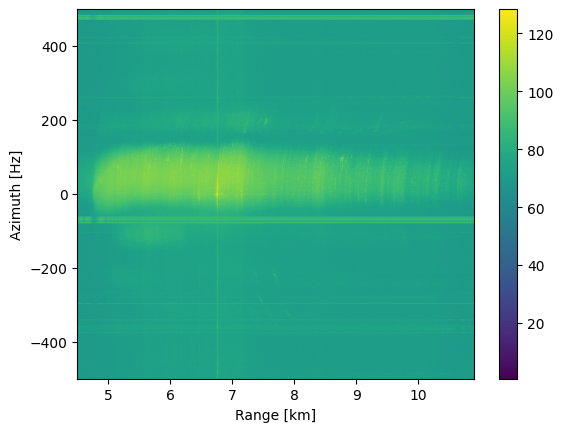

In [29]:
# In a top-down direction
f_az = np.linspace(-float(PRF)/2, float(PRF)/2, int(sz_col))

raw_FFT_az = np.zeros((sz_col, sz_raw), dtype=complex)

for i in range(0, sz_raw):
    raw_FFT_az[:, i] = np.fft.fftshift(np.fft.fft(raw_comp[:,i]))

''' # Point target visualizarion
x_zoom1 = 6000
x_zoom2 = 6500
plt.imshow(20*np.log10(np.abs(raw_RCMC[:, x_zoom1:x_zoom2])), cmap='viridis', aspect='auto', extent=(rang[x_zoom1], rang[x_zoom2], -float(PRF)/2, float(PRF)/2))
'''
plt.imshow(20*np.log10(np.abs(raw_FFT_az)), cmap='viridis', aspect='auto', extent=(rang[0], rang[-1], -float(PRF)/2, float(PRF)/2))
plt.colorbar()
plt.xlabel("Range [km]")
plt.ylabel("Azimuth [Hz]")
plt.show()


# **Range Cell Migration Correction (RCMC)**

Once in the frequency domain, range migration correction is applied. This correction involves shifting each range vector depending on the frequency. Starting from 1 and knowing that t = $f λ r_0/(2v^2)$, it is deduced that the shift to be applied is given by:

$ \vec{r_j} = \vec{r_0} \left(1 + \frac{1}{8}\left(\frac{\lambda^2 f^2}{v^2}\right)^2\right) $

where $\vec{r_0}$ is the range vector corresponding to the window in which the radar and the surface were closest, and $\vec{r_j}$ is the range vector corresponding to each row. Since shifting may lead to the point at $r_1$ not being sampled, interpolation is necessary to correctly fit the data.

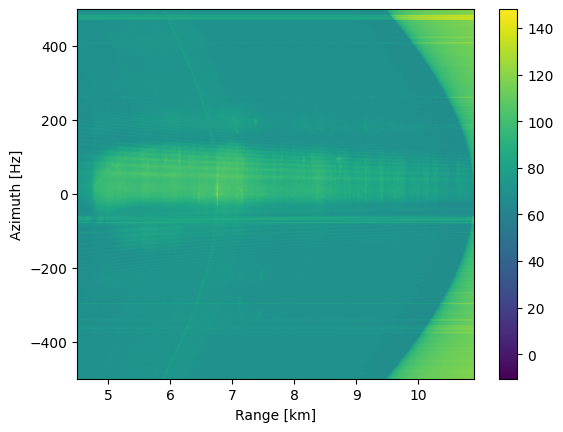

In [30]:
raw_RCMC = np.zeros((sz_col, sz_raw), dtype=complex)

for i in range(0, sz_col):
    rf = rang*(1 + (1/8)*(lamb*f_az[i]/vr)**2)
    f = interpolate.interp1d(rang, raw_FFT_az[i, :], kind='linear', fill_value = 'extrapolate')

    raw_RCMC[i] = f(rf)

''' # Point target visualizarion
plt.imshow(20*np.log10(np.abs(raw_RCMC[:, x_zoom1:x_zoom2])), cmap='viridis', aspect='auto', extent=(rang[x_zoom1], rang[x_zoom2], -float(PRF)/2, float(PRF)/2))
'''
plt.imshow(20*np.log10(np.abs(raw_RCMC)), cmap='viridis', aspect='auto', extent=(rang[0], rang[-1], -float(PRF)/2, float(PRF)/2))
plt.colorbar()
plt.xlabel("Range [km]")
plt.ylabel("Azimuth [Hz]")
plt.show()

# **Compression and IFFT in Azimuth**

Once the correction is performed, azimuth compression can be carried out. Compression is done using a matched filter whose impulse response is given by:

$h_{ac}(t) = s^*(-t) = \text{rect} \left(\frac{t}{2T_{ac}}\right) e^{-j\pi \frac{BW_{ac}}{T_{ac}} t^2}$

where $T_{ac} = \frac{0.886\lambda r}{L_a v}$ is the azimuth chirp time, $BW_{ac} = \frac{1.772v}{L_a}$  is the azimuth chirp bandwidth, and $L_a$ is the physical length of the radar antenna.

To efficiently apply this filter, a transformation to the frequency domain is performed, and the convolution theorem is used on each column of the data matrix. That is, the multiplication of each point of the filter with each point of the column is carried out, followed by the inverse Fourier transform to return the output to the azimuth distance domain.

## **Construcción chirp en acimut**

In [31]:
# Azimuth chirp bandwidth
BW_az = float(2 * vr * 0.886 / La)

# Azimuth chirp time
T_az = 886 * lamb * rang / (La * vr)

# Matrix to store compressed rows
raw_comp_az = np.zeros((sz_col, sz_raw), dtype=complex)

# Matched filter
for i in range(0, sz_raw):
    K = float(BW_az / T_az[i])
    # Azimuth chirp is sampled at PRF
    T_p = np.arange(-T_az[i] / 2, T_az[i] / 2, float(1 / (1 * PRF)))

    s_az = np.exp(-1j * np.pi * K * T_p**2)
    h_az = np.conjugate(s_az)

    aux_ifft = np.fft.ifft(np.fft.ifftshift(raw_RCMC[:, i]))

    raw_comp_az[:, i] = compression(aux_ifft, h_az)

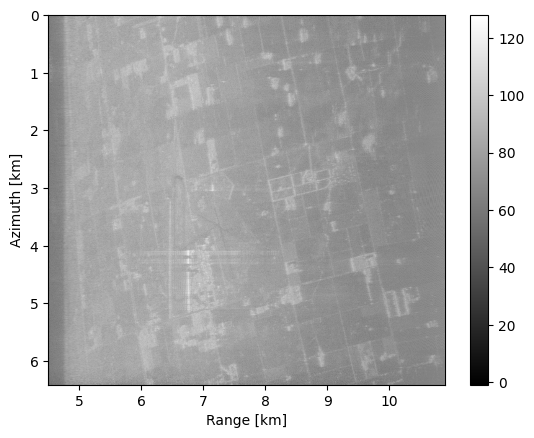

In [32]:
''' # Point target visualizarion
plt.imshow(20*np.log10(np.abs(raw_RCMC[:, x_zoom1:x_zoom2])), cmap='viridis', aspect='auto', extent=(rang[x_zoom1], rang[x_zoom2], -float(PRF)/2, float(PRF)/2))
'''
plt.imshow(20*np.log10(np.abs(raw_comp_az)), cmap='gray', aspect='auto', extent=(rang[0], rang[-1], maximum_azimuth, 0))
plt.colorbar()
plt.xlabel("Range [km]")
plt.ylabel("Azimuth [km]")

plt.show()